# Preprocessing Demo

This is an interactive demo displaying how CLARIFY preprocesses the data with plotly visualizations. All of these functions can be run in one step via the command line (either the preprocess function in main.py or running "python main.py" itself).

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
%load_ext autoreload
%autoreload 2

import src.preprocess as pre
import src.visualize as vis
pio.renderers.default = "png"


## Read in Example Data (SeqFISH+)

In [3]:
seqfish_counts_df = pd.read_csv("./data/seqFISH/counts.csv")
seqfish_celltype_df = pd.read_csv("./data/seqFISH/cell_type_1.csv")
seqfish_coords_df = pd.read_csv("./data/seqFISH/coord.csv")
seqfish_coords_df["Cell_ID"] = seqfish_celltype_df["Cell_ID"]
seqfish_df = seqfish_counts_df.copy()

numcells, numgenes = seqfish_counts_df.shape
numgenes = 45

seqfish_df.insert(0,'Cell_ID', seqfish_celltype_df["Cell_ID"])
seqfish_df.insert(1,'X', seqfish_coords_df["X"])
seqfish_df.insert(2,'Y', seqfish_coords_df["Y"])
seqfish_df.insert(3,'Cell_Type', seqfish_celltype_df["Cell_class_name"])
seqfish_df.to_csv("data/seqFISH/seqfish_dataframe.csv", index=False)
seqfish_df

,Cell_ID,X,Y,Cell_Type,4931431F19Rik,4932429P05Rik,Abca15,Abca9,Adcy4,Aldh3b2,...,calb1,gda,slc5a7,sema3e,mfge8,lyve1,loxl1,slco1c1,amigo2,kcnip
0,1,265.76,-231.14,neuron,1.83,1.52,2.41,-0.02,-0.28,1.95,...,0.12,-1.32,-2.06,-1.32,0.19,-2.20,-1.54,-1.40,2.51,0.60
1,2,290.48,-261.52,neuron,0.38,-0.04,0.59,0.03,0.93,0.49,...,-1.60,-0.64,-2.47,-1.34,0.00,0.22,-1.46,0.22,1.88,2.05
2,3,257.12,-133.35,neuron,0.82,0.12,0.67,-0.29,-0.42,-0.04,...,-0.66,-0.78,-1.07,-2.09,0.09,0.32,-2.29,0.15,3.20,2.30
3,4,753.46,-261.14,neuron,0.04,-1.27,-0.30,-0.52,-2.08,0.92,...,-0.85,-1.16,-1.29,-0.57,0.99,-0.19,-1.49,0.65,3.04,2.00
4,5,700.01,-169.05,neuron,0.52,0.44,-1.05,0.48,-0.49,2.29,...,-0.65,-0.97,-1.29,-1.77,1.09,-1.17,-2.11,0.36,2.47,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,1593,1129.06,-1669.57,neuron,-0.17,-0.50,1.03,0.90,0.23,0.48,...,-0.79,-0.31,-3.45,-2.60,-1.13,-1.97,-0.82,-1.53,2.21,0.54
1593,1594,1044.02,-1872.66,neuron,0.20,0.95,0.57,0.77,-2.34,-0.29,...,-0.57,-0.33,-1.13,-0.68,-0.06,-1.55,-0.43,-0.60,2.66,0.23
1594,1595,1388.76,-1880.47,neuron,-1.06,-0.18,-0.33,-0.05,-0.26,-0.22,...,1.04,0.54,1.38,0.90,-0.41,-1.69,0.36,-0.49,0.80,0.39
1595,1596,5172.85,-1340.96,neuron,-1.99,-0.25,1.34,0.00,-0.01,0.95,...,-1.28,-1.25,1.58,-2.68,-0.77,0.27,-0.60,-0.14,-2.66,0.37


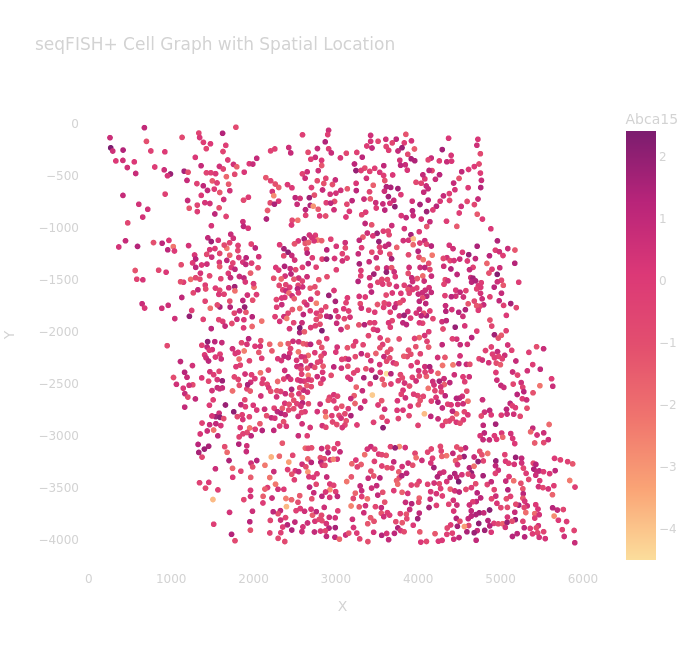

In [8]:
gene = "Abca15"
pio.renderers.default = "notebook_connected"
fig = vis.visualize_celllevel_graph(seqfish_df, gene, title =  f"seqFISH+ Cell Graph with Spatial Location", publication=True)
fig.show("png")

# Preprocessing
1. Infer starting Cell-Specific GRNs (CeSpGRN)
2. Construct Cell-Level Graph from ST Data
3. Construct Gene-Level Graph from ST Data + GRNs

### 1. Inferring Cell-Specific GRNs

In [4]:
# Code to infer

In [4]:
grns = np.load("./out/preprocessing_output/seqfish_grns.npy") # shape (ncells, ngenes, ngenes)
# seqfish_counts_df.columns[:45]

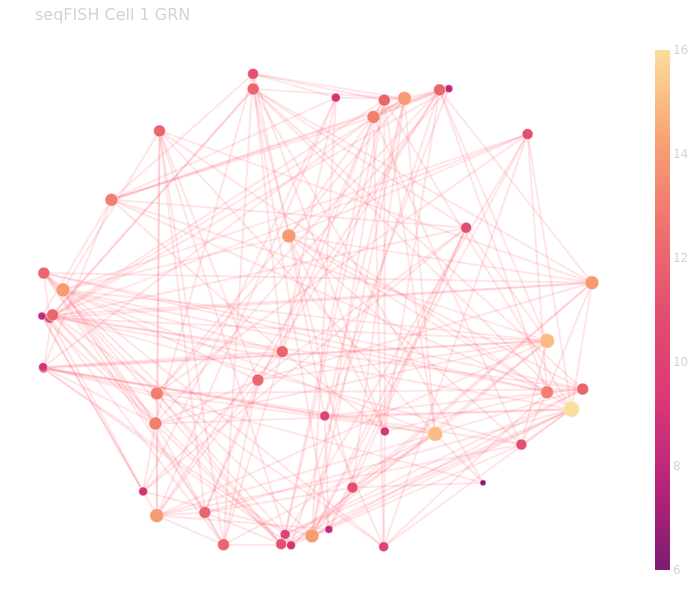

In [5]:
gene_attributes = {i:genename for i, genename in enumerate(seqfish_counts_df.columns[:45])}
pio.renderers.default = "notebook_connected"
fig = vis.visualize_grn_igviz(grns[0],gene_attributes, "seqFISH Cell 1 GRN")
fig.show("png")

### 2. Constructing Cell-Level Graph

In [6]:
celllevel_adj, edges = pre.construct_celllevel_graph(seqfish_df, 5, get_edges=True)


2. Construct Cell-Level Graph from ST Data: 100%|██████████| 1597/1597 [00:00<00:00, 6970.54it/s]


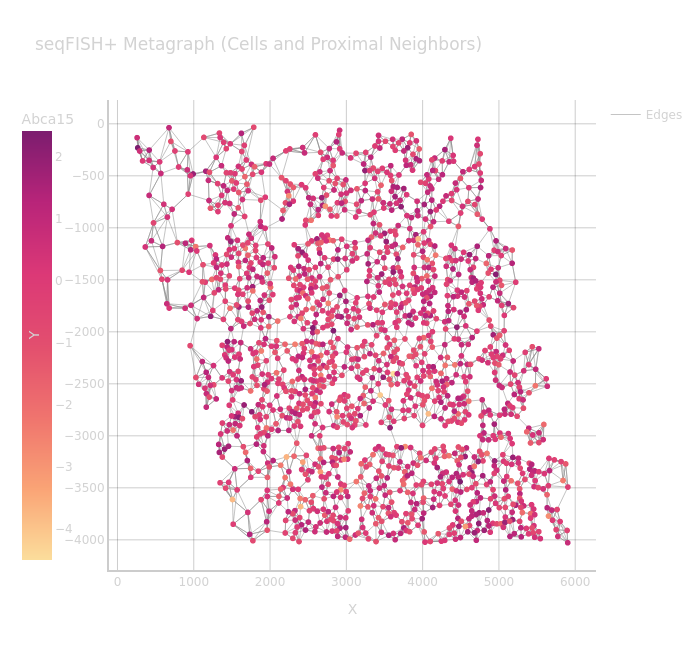

In [9]:
cell_level_graph_fig = vis.visualize_celllevel_graph(seqfish_df,gene,title = f"seqFISH+ Metagraph (Cells and Proximal Neighbors)",edge_trace=edges)
cell_level_graph_fig.show("png")

### 3. Construct Gene Level Graph

In [10]:
gene_level_graph, num2gene, gen2num = pre.construct_genelevel_graph(grns, celllevel_adj, node_type="int")

len(gene_level_graph.nodes())

3b. Constructing Gene-Level Graph: 100%|██████████| 1597/1597 [00:09<00:00, 160.51it/s]


71865

In [16]:
np.load('./out/preprocessing_output/celllevel_edgelist.npy')

array([[   0,    0,    0, ..., 1596, 1596, 1596],
       [   1,    2,    6, ..., 1508, 1564, 1514]])